In [86]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [20]:
train_data = pd.read_pickle("./train.pkl")
val_data = pd.read_pickle("./val.pkl")
train_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
103,104,3,"Johansson, Mr. Gustaf Joel",male,33.0,0,0,7540,8.6542,NaN,S,0
349,350,3,"Dimic, Mr. Jovan",male,42.0,0,0,315088,8.6625,NaN,S,0
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0
345,346,2,"Brown, Miss. Amelia ""Mildred""",female,24.0,0,0,248733,13.0000,F33,S,1
652,653,3,"Kalvik, Mr. Johannes Halvorsen",male,21.0,0,0,8475,8.4333,NaN,S,0


In [21]:
def split_data(data):
    X = data.drop("Survived", axis=1)
    y = data.loc[:,["Survived"]]

    return([X,y])

In [22]:
def test_model(preprocessing_pipeline, train_data, val_data):
    model_pipeline = Pipeline([("preprocessing",preprocessing_pipeline), ("KNN",KNeighborsClassifier())])

    X_train, y_train = split_data(train_data)
    X_val, y_val = split_data(val_data)

    X_combined = pd.concat([X_train,X_val])
    y_combined = pd.concat([y_train,y_val])

    test_fold = np.array([-1]*X_train.shape[0] + [0]*X_val.shape[0])
    ps = PredefinedSplit(test_fold)
    
    param_grid = [{"KNN__n_neighbors":[1,3,5,7,10], "KNN__weights":("uniform","distance")}]

    clf = GridSearchCV(model_pipeline,
            param_grid,
            cv=ps,
            scoring="accuracy",
            n_jobs=-1,
            verbose=1,
            refit=True)

    clf.fit(X_combined, y_combined.to_numpy().ravel())
    
    cv_results = pd.DataFrame(clf.cv_results_)
    cv_test_score = max(cv_results["mean_test_score"])
    print(cv_test_score*100)
    
    return(clf,cv_test_score*100)

In [23]:
sex_pipeline = make_pipeline(OrdinalEncoder(handle_unknown='error'))
age_pipeline = make_pipeline(SimpleImputer(),StandardScaler())
fare_pipeline = make_pipeline(SimpleImputer(),MinMaxScaler())
loc_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer(
                transformers = [
                    ("sex", sex_pipeline, ["Sex"]),
                    ("pass", "passthrough", ["Pclass"]),
                    ("age", age_pipeline, ["Age"]),
                    ("fare", fare_pipeline, ["Fare"]),
                    ("loc", loc_pipeline, ["Embarked"])
                ],
                remainder = "drop"
)

clf, acc = test_model(preprocessing, train_data, val_data)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
82.0


In [41]:
cabin_transformer = FunctionTransformer(lambda x : x.isna())

In [73]:
sex_pipeline = make_pipeline(OrdinalEncoder(handle_unknown='error'))
age_pipeline = make_pipeline(SimpleImputer(),StandardScaler())
fare_pipeline = make_pipeline(SimpleImputer(),MinMaxScaler())
loc_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore"))
cabin_pipeline = make_pipeline(cabin_transformer)

preprocessing = ColumnTransformer(
                transformers = [
                    ("sex", sex_pipeline, ["Sex"]),
                    ("pass", "passthrough", ["Pclass"]),
                    ("age", age_pipeline, ["Age"]),
                    ("fare", fare_pipeline, ["Fare"]),
                    #("loc", loc_pipeline, ["Embarked"]),
                    #("cabin", cabin_pipeline, ["Cabin"])
                ],
                remainder = "drop"
)

clf, acc = test_model(preprocessing, train_data, val_data)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
83.0


In [74]:
def model_predict(test_path,model):
    test_data = pd.read_csv(test_path)
    preds = model.predict(test_data)
    
    preds = pd.DataFrame([[x,y] for x,y in zip(test_data["PassengerId"],preds)], columns=["PassengerId","Survived"])
    
    return(preds)

In [75]:
knn_preds = model_predict("../datasets/test.csv",clf)
knn_preds.to_csv("../knn_test_pred.csv", index=False)

# CV Training

In [78]:
train_data = pd.read_csv("../datasets/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [79]:
def split_data(data):
    X = data.drop("Survived", axis=1)
    y = data.loc[:,["Survived"]]

    return([X,y])

In [80]:
def test_model(preprocessing_pipeline, train_data, model,params):
    model_pipeline = Pipeline([("preprocessing",preprocessing_pipeline), ("model",model)])

    clf = GridSearchCV(model_pipeline,
            params,
            cv=10,
            scoring="accuracy",
            n_jobs=-1,
            verbose=1,
            refit=True)

    X,y = split_data(train_data)
    clf.fit(X, y.to_numpy().ravel())
    
    cv_results = pd.DataFrame(clf.cv_results_)
    cv_test_score = max(cv_results["mean_test_score"])
    print(cv_test_score*100)
    
    return(clf,cv_test_score*100)

In [81]:
cabin_transformer = FunctionTransformer(lambda x : x.isna())

In [88]:
sex_pipeline = make_pipeline(OrdinalEncoder(handle_unknown='error'))
age_pipeline = make_pipeline(SimpleImputer(),StandardScaler())
fare_pipeline = make_pipeline(SimpleImputer(),MinMaxScaler())
loc_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore"))
cabin_pipeline = make_pipeline(cabin_transformer)

preprocessing = ColumnTransformer(
                transformers = [
                    ("sex", sex_pipeline, ["Sex"]),
                    ("pass", "passthrough", ["Pclass"]),
                    ("age", age_pipeline, ["Age"]),
                    ("fare", fare_pipeline, ["Fare"]),
                    #("loc", loc_pipeline, ["Embarked"]),
                    #("cabin", cabin_pipeline, ["Cabin"])
                ],
                remainder = "drop"
)

In [89]:
#KNN
param_grid = [{"model__n_neighbors":[1,3,5,7,10], "model__weights":("uniform","distance")}]

clf, acc = test_model(preprocessing, train_data, KNeighborsClassifier(), param_grid)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
82.27465667915105


In [90]:
def plot_scores(clf):
    res = pd.DataFrame(clf.cv_results_)
    res = res.loc[res["rank_test_score"]==1,:]

    score_cols = [x for x in res.columns if ("test_score" in x and "split" in x)]
    res = res.loc[:,score_cols]
    KNN_score = res.to_numpy().squeeze()

    plt.plot([1]*10, KNN_score, ".")
    plt.boxplot([KNN_score], vert=True, labels=['KNN'])
    plt.title('Boxplot of Array Values (Matplotlib)')
    plt.ylabel('Value')
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for better readability
    plt.show()

/var/folders/k5/qx7l6y390hd316r0yv70rlr00000gn/T/ipykernel_42187/652926003.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([KNN_score], vert=True, labels=['KNN'])


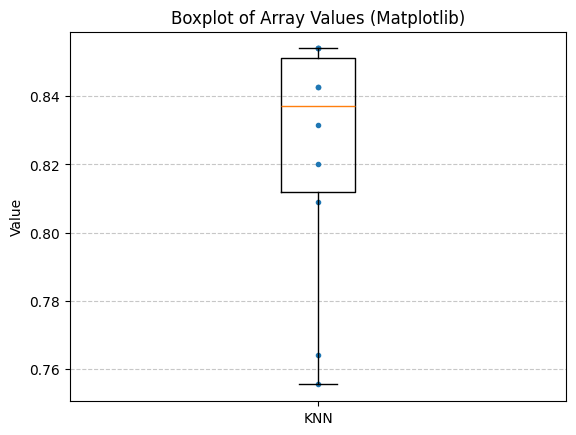

In [91]:
plot_scores(clf)

Variance across CV splits is very high. Likely causing test score to be low.